In [1]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine


from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [3]:
df = pd.read_csv("../data/fars.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [4]:
X.shape

(100968, 29)

In [5]:
pd.value_counts(y)

1    42116
4    20007
2    15072
5    13890
6     8674
7      901
3      299
0        9
Name: count, dtype: int64

# model

In [5]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

In [6]:
train_acc = []
test_acc = []

stack = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

In [9]:
learning_rate = 0.3
bins = 2
lam = 100
stack = []
losses = []

max_depth = 10
tolerance = 0.001


total_size = 10
elite_size = 10


for i in range(1000):
    eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,learning_rate,bins,max_depth,lam)

    for j in range(3):
        eg.evolve(total_size,elite_size,tolerance=tolerance,verbose=0)
        
    stack,losses = eg.adding_unique_node(stack,losses,eg.nodes,tolerance=tolerance)
    print(len(stack),i)
    # if len(stack) > 8000:
    #         break

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)
previous_sse = np.sum(np.power(y_train_one_hot - p,2))
score = []

train_acc = []
test_acc = []

train_sse = []
test_sse = []


counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))


    score.append(previous_sse - train_sse[-1])
    previous_sse = train_sse[-1]


    pred = np.argmax(p,axis=1)
    train_acc.append(accuracy_score(pred,y_train))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(accuracy_score(test_pred,y_test))
print(train_sse[-1],test_sse[-1],i+1,len(a))
print('\t',train_acc[-1],test_acc[-1],i+1,len(a))

30 0
48 1
57 2
60 3
61 4
66 5
71 6
79 7
83 8
85 9
87 10
91 11
95 12
97 13
99 14
103 15
105 16
106 17
108 18
110 19
112 20
113 21
116 22
119 23
119 24
123 25
123 26
126 27
129 28
132 29
132 30
133 31
135 32
136 33
139 34
139 35
140 36
142 37
142 38
143 39
144 40
145 41
148 42
149 43
153 44
156 45
156 46
160 47
165 48
165 49
165 50
169 51
169 52
172 53
173 54
173 55
174 56
174 57
174 58
176 59
176 60
176 61
177 62
177 63
177 64
177 65
177 66
177 67
180 68
180 69
181 70
181 71
181 72
182 73
182 74
184 75
186 76
187 77
189 78
190 79
192 80
192 81
194 82
194 83
194 84
194 85
194 86
198 87
198 88
198 89
198 90
198 91
199 92
199 93
198 94
200 95
200 96
200 97
200 98
201 99
201 100
201 101
202 102
203 103
203 104
203 105
203 106
203 107
203 108
203 109
204 110
204 111
205 112
206 113
207 114
208 115
208 116
208 117
208 118
208 119
208 120
208 121
208 122
208 123
208 124
208 125
208 126
209 127
209 128
209 129
209 130
209 131
209 132
209 133
209 134
209 135
209 136
209 137
209 138
209 139
212 1

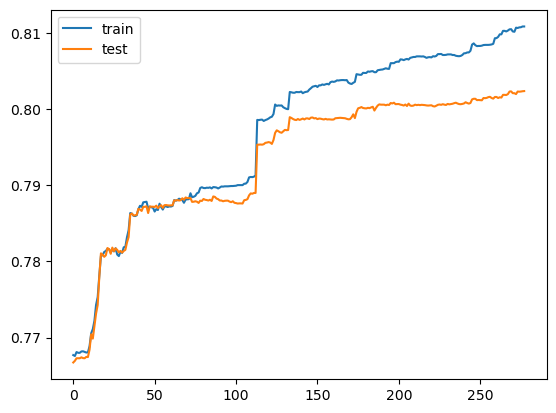

0.8108311544251644 0.8023532208224388 0.8023532208224388


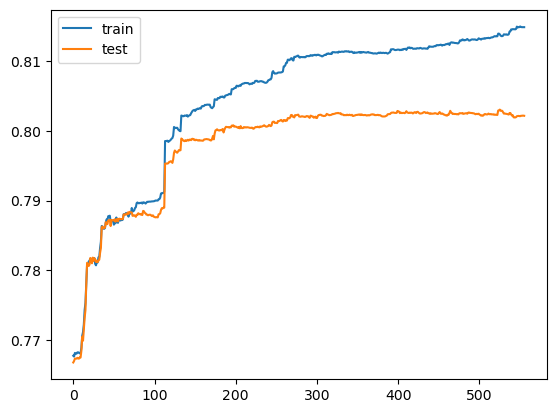

0.8149314634339593 0.8021947547737898 0.8030861262974408


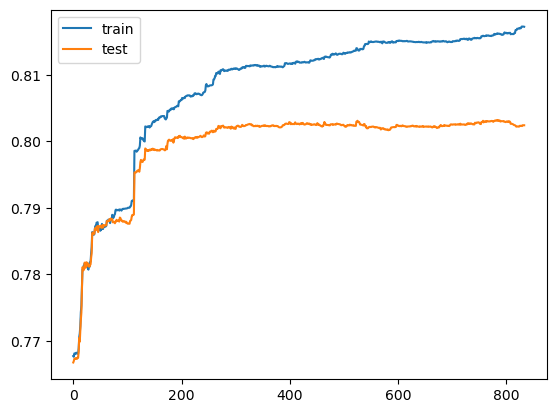

0.8172292211393709 0.8024126455906821 0.8031851675778464


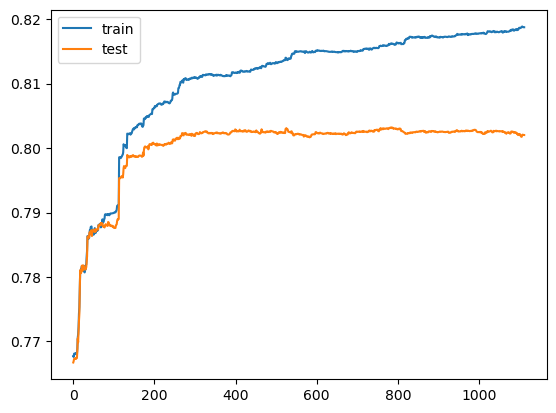

0.8187346486015371 0.8020164804690595 0.8031851675778464


KeyboardInterrupt: 

In [10]:
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
train_acc = []
test_acc = []

train_sse = []
test_sse = []

log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)
previous_sse = np.sum(np.power(y_train_one_hot - p,2))

score = []

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

for _ in range(100):

    for i,node in enumerate(a):
        node.estimator.lam = 10
        grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

        test_grads = node.predict_grad(X_test)
        test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


        train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
        test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))

        score.append(previous_sse - train_sse[-1])
        previous_sse = train_sse[-1]

        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(pred,y_train))
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(test_pred,y_test))
        
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.legend(["train","test"])
    plt.show()
    
    print(train_acc[-1],test_acc[-1],max(test_acc))

In [13]:
sum([n.numNode for n in stack])

1080

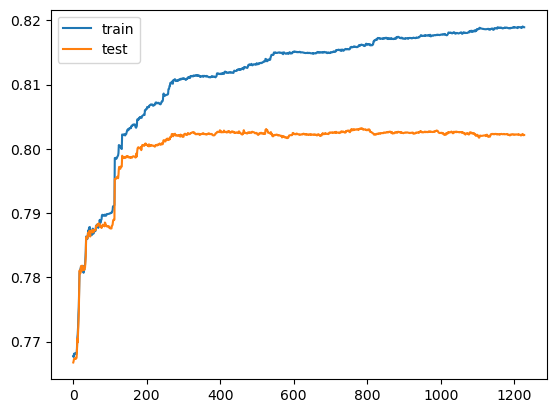

In [14]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train","test"])

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00     21058
           2       0.95      0.99      0.97      7536
           3       0.99      0.99      0.99       150
           4       0.97      1.00      0.98     10004
           5       0.97      0.95      0.96      6945
           6       0.99      0.87      0.93      4337
           7       0.89      0.94      0.91       450

    accuracy                           0.98     50484
   macro avg       0.97      0.97      0.97     50484
weighted avg       0.98      0.98      0.98     50484

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      1.00      1.00     21058
           2       0.52      0.53      0.53      7536
           3       0.41      0.38      0.39       149
           4       0.86      0.86      0.86     10003
           5       0.41 

# XGBoost

In [11]:
import xgboost


In [12]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

print(classification_report(y_train,xgb.predict(X_train),digits=5))
print(classification_report(y_test,xgb.predict(X_test),digits=5))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0    1.00000   0.80000   0.88889         5
           1    0.99990   0.99886   0.99938     21058
           2    0.69758   0.71961   0.70843      7536
           3    0.90840   0.79333   0.84698       150
           4    0.86929   0.99060   0.92599     10003
           5    0.57507   0.68611   0.62570      6945
           6    0.75054   0.23934   0.36294      4337
           7    0.86624   0.90667   0.88599       450

    accuracy                        0.84581     50484
   macro avg    0.83338   0.76681   0.78054     50484
weighted avg    0.84756   0.84581   0.83385     50484

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         4
           1    0.99995   0.99862   0.99929     21058
           2    0.60187   0.63110   0.61614      7536
           3    0.55556   0.36913   0.44355       149
           4    0.85868   0.97911   0.91495     10004
           5    0.47034 

c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhouz\anaconda3\envs\BStackGP\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(800, 5.46125, 39470)